In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer, Custom Generator Inject 0.1% Unseen, NAICS hierarchy codes
Here, instead of randomizing the input training data, I use a custom data generator to inject random cases for each batch.  This is to help the model learn to handle unseen codes

Encode the base NAICS and higher hierarchy levels.  

Custom data generators are used to retrieve data at each batch or epoch, and can be used to modify data for every batch or epoch.  In future scripts, I modify at the batch level, injecting random "1" values.   See also  https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/utils/Sequence

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

## Input Data

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [7]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [9]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [10]:
# NAICS feature - just bas
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [11]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [12]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [13]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 14), y:(446848,)


In [14]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 14), y:(95604,)


In [15]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

In [16]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-19 21:39:47.521352: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-19 21:39:47.521425: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-19 21:39:47.521441: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-19 21:39:47.521539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 21:39:47.521588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

##### Use data generator to inject 1 values into training data

In [18]:
generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = 0.001,
                               injection_value = 1)

In [19]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [20]:
this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                              callbacks=[callback])

Epoch 1/20


2024-05-19 21:39:48.977969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4622 - auc: 0.3370 - auc_1: 0.7002

2024-05-19 21:44:14.793734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 292s 21ms/step - loss: 0.4622 - auc: 0.3370 - auc_1: 0.7002 - val_loss: 0.4566 - val_auc: 0.3704 - val_auc_1: 0.7237
Epoch 2/20
13964/13964 [==============================] - 298s 21ms/step - loss: 0.4543 - auc: 0.3588 - auc_1: 0.7171 - val_loss: 0.4513 - val_auc: 0.3788 - val_auc_1: 0.7280
Epoch 3/20
13964/13964 [==============================] - 382s 27ms/step - loss: 0.4522 - auc: 0.3659 - auc_1: 0.7214 - val_loss: 0.4538 - val_auc: 0.3779 - val_auc_1: 0.7278
Epoch 4/20
13964/13964 [==============================] - 343s 25ms/step - loss: 0.4511 - auc: 0.3687 - auc_1: 0.7236 - val_loss: 0.4521 - val_auc: 0.3815 - val_auc_1: 0.7296
Epoch 5/20
13964/13964 [==============================] - 421s 30ms/step - loss: 0.4504 - auc: 0.3720 - auc_1: 0.7253 - val_loss: 0.4547 - val_auc: 0.3852 - val_auc_1: 0.7301


In [21]:
this_history_df = sbnn_model.process_history(this_history)

In [22]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('18_REPORT_fit_history.csv'))

<Axes: >

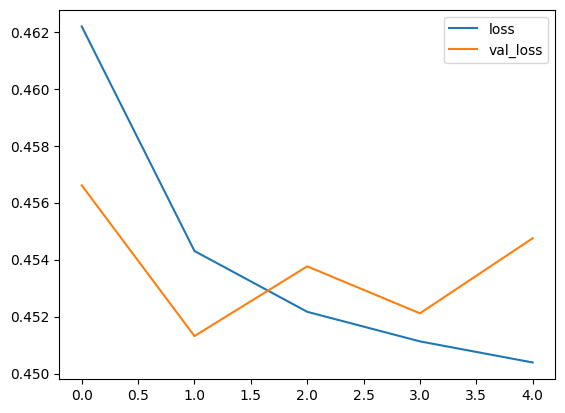

In [23]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

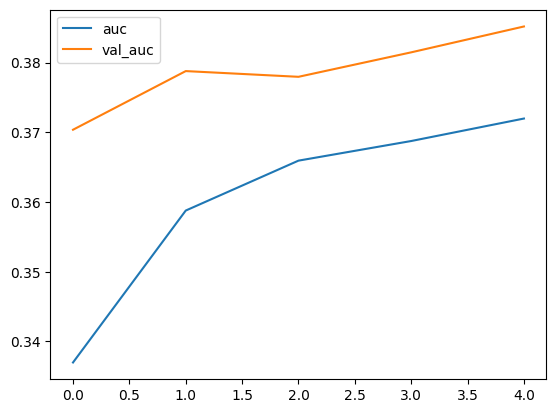

In [24]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

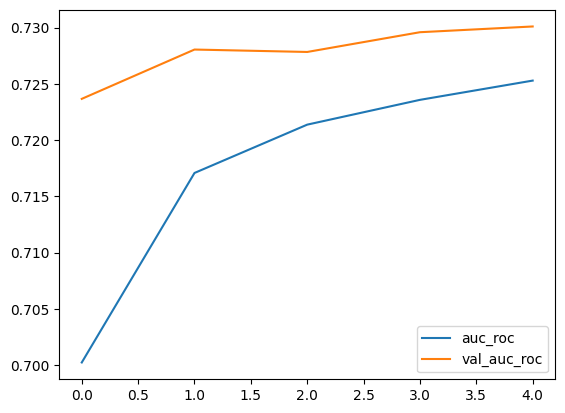

In [25]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [26]:
this_model.save(Path(setup.temp_path).joinpath('18_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [27]:
all_predictions = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])

   12/21735 [..............................] - ETA: 1:41   

2024-05-19 22:08:46.609748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 64s 3ms/step


In [28]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [29]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.322119
target,0.322119,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [30]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [31]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [32]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
9,0.18,0.452507
10,0.20,0.450551
8,0.16,0.448375


In [33]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.18

##### Append binary predictions to probability predictions

In [34]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [35]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.564572
1    0.435428
Name: proportion, dtype: float64

In [36]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('18_DATA_predictions.parquet'))

## Metrics

In [37]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('18_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.640564,0.447742,0.324416,0.722337,0.375768,0.727433,NaN
1,train,0.652900,0.452507,0.332288,0.709027,0.386617,0.733145,NaN
2,val,0.652389,0.452459,0.333212,0.704624,0.385261,0.730195,NaN
0,test,0.649455,0.447326,0.329077,0.698223,0.378239,0.725236,0.0
1,test,0.625785,0.448387,0.317444,0.763202,0.373175,0.733581,1.0
